# 1. Imports & Station List

In [18]:
import pandas as pd
import numpy as np
import glob

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [19]:
TARGET_STATIONS = [
    "MIT at Mass Ave / Amherst St",
    "Central Square at Mass Ave / Essex St",
    "MIT Pacific St at Purrington St",
    "Harvard Square at Mass Ave / Dunster St",
    "Boylston St at Massachusetts Ave",
    "Charles St at Cambridge St",
    "Forsyth St at Huntington Ave",
    "Boylston St at Fairfield St",
    "Christian Science Plaza - Massachusetts Ave at Westland Ave",
    "MIT Stata Center at Vassar St / Main St",
]


# 2. Load the data

In [20]:
# ---------------------------------------------------------
# 1. LOAD 12 MONTHS OF BLUEBIKES TRIP DATA
# ---------------------------------------------------------

tripdata_path = "2024_data/"   # <-- change to your folder

all_files = glob.glob(tripdata_path + "2024*-bluebikes-tripdata.csv")

print("Files detected:")
for f in all_files:
    print(f)

df_list = []
for filename in all_files:
    print("Loading:", filename)
    df_month = pd.read_csv(filename)
    df_list.append(df_month)

rides = pd.concat(df_list, ignore_index=True)
print("Total rows loaded:", len(rides))

Files detected:
2024_data/202407-bluebikes-tripdata.csv
2024_data/202409-bluebikes-tripdata.csv
2024_data/202403-bluebikes-tripdata.csv
2024_data/202404-bluebikes-tripdata.csv
2024_data/202405-bluebikes-tripdata.csv
2024_data/202402-bluebikes-tripdata.csv
2024_data/202408-bluebikes-tripdata.csv
2024_data/202401-bluebikes-tripdata.csv
2024_data/202406-bluebikes-tripdata.csv
2024_data/202410-bluebikes-tripdata.csv
2024_data/202411-bluebikes-tripdata.csv
2024_data/202412-bluebikes-tripdata.csv
Loading: 2024_data/202407-bluebikes-tripdata.csv
Loading: 2024_data/202409-bluebikes-tripdata.csv
Loading: 2024_data/202403-bluebikes-tripdata.csv
Loading: 2024_data/202404-bluebikes-tripdata.csv
Loading: 2024_data/202405-bluebikes-tripdata.csv
Loading: 2024_data/202402-bluebikes-tripdata.csv
Loading: 2024_data/202408-bluebikes-tripdata.csv
Loading: 2024_data/202401-bluebikes-tripdata.csv
Loading: 2024_data/202406-bluebikes-tripdata.csv
Loading: 2024_data/202410-bluebikes-tripdata.csv
Loading: 2024_

In [21]:

# ---------------------------------------------------------
# 2. LOAD STATION FEATURE DATA (feature.csv)
# ---------------------------------------------------------

station_features = pd.read_csv("feature.csv")   # <-- your uploaded file

# Rename columns to shorter / code-friendly names
station_features = station_features.rename(columns={
    "Station_id": "station_id",
    "Station_name": "station_name",
    "Station latitude": "station_lat",
    "Station longitude": "station_lng",
    "Distance to nearest subway stop (m)": "dist_subway_m",
    "Distance to nearest bus stop (m)": "dist_bus_m",
    "Distance to nearest university (m)": "dist_university_m",
    "Distance to nearest business district": "dist_business",
    "Distance to nearest residential area": "dist_residential",
    "Population density around station": "pop_density",
    "Employment density around station": "emp_density",
    "Number of restaurants/cafes nearby": "restaurant_count",
    "Restaurant/cafes density around station": "restaurant_density",
})

# This file is purely station-level (no time info), so we just keep the static columns.
station_features = station_features[[
    "station_name",
    "station_lat",
    "station_lng",
    "dist_subway_m",
    "dist_bus_m",
    "dist_university_m",
    "dist_business",
    "dist_residential",
    "pop_density",
    "emp_density",
    "restaurant_count",
    "restaurant_density",
]]


## 2.1 Build hourly inflow / outflow per station

In [22]:
rides["started_at"] = pd.to_datetime(rides["started_at"], format="mixed")
rides["ended_at"] = pd.to_datetime(rides["ended_at"], format="mixed")


# Floor to hour for aggregation
rides["start_hour"] = rides["started_at"].dt.floor("H")
rides["end_hour"] = rides["ended_at"].dt.floor("H")

# Outflow: bikes leaving the station
out_df = (
    rides[rides["start_station_name"].isin(TARGET_STATIONS)]
    .groupby(["start_station_name", "start_hour"])
    .size()
    .reset_index(name="out_count")
    .rename(columns={"start_station_name": "station_name",
                     "start_hour": "hour"})
)

# Inflow: bikes arriving at the station
in_df = (
    rides[rides["end_station_name"].isin(TARGET_STATIONS)]
    .groupby(["end_station_name", "end_hour"])
    .size()
    .reset_index(name="in_count")
    .rename(columns={"end_station_name": "station_name",
                     "end_hour": "hour"})
)

# Merge inflow & outflow into one panel
panel = pd.merge(
    out_df,
    in_df,
    how="outer",
    on=["station_name", "hour"]
)

# Replace NaNs with 0 (no trips that hour)
panel[["in_count", "out_count"]] = panel[["in_count", "out_count"]].fillna(0).astype(int)

panel.head()


/var/folders/qd/ryt2vxzx55vckk3tg4kwwx_40000gn/T/ipykernel_59578/3698921882.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rides["start_hour"] = rides["started_at"].dt.floor("H")
/var/folders/qd/ryt2vxzx55vckk3tg4kwwx_40000gn/T/ipykernel_59578/3698921882.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rides["end_hour"] = rides["ended_at"].dt.floor("H")


,station_name,hour,out_count,in_count
0,Boylston St at Fairfield St,2024-01-01 00:00:00,2,0
1,Boylston St at Fairfield St,2024-01-01 01:00:00,3,1
2,Boylston St at Fairfield St,2024-01-01 02:00:00,2,0
3,Boylston St at Fairfield St,2024-01-01 07:00:00,0,1
4,Boylston St at Fairfield St,2024-01-01 11:00:00,0,1


## 2.2 Merge with station-level features

In [23]:
# Keep only the columns you really want from station_features
station_features_clean = station_features[[
    "station_name",
    "station_lat",
    "station_lng",
    "dist_subway_m",
    "dist_bus_m",
    "dist_university_m",
    "dist_business",
    "dist_residential",
    "pop_density",
    "emp_density",
    "restaurant_count",
    "restaurant_density",
]]

# Merge
panel = panel.merge(
    station_features_clean,
    on="station_name",
    how="left"
)

#Time-based features
panel["month"] = panel["hour"].dt.month
panel["day_of_week"] = panel["hour"].dt.dayofweek    # 0 = Monday
panel["hour_of_day"] = panel["hour"].dt.hour
panel["is_weekend"] = panel["day_of_week"].isin([5, 6]).astype(int)  # Sat/Sun



panel.head()


,station_name,hour,out_count,in_count,station_lat,station_lng,dist_subway_m,dist_bus_m,dist_university_m,dist_business,dist_residential,pop_density,emp_density,restaurant_count,restaurant_density,month,day_of_week,hour_of_day,is_weekend
0,Boylston St at Fairfield St,2024-01-01 00:00:00,2,0,42.348,-71.0824,276.328,71.401,283.066,1.629905,0.352641,High,High,110.0,Very High,1,0,0,0
1,Boylston St at Fairfield St,2024-01-01 01:00:00,3,1,42.348,-71.0824,276.328,71.401,283.066,1.629905,0.352641,High,High,110.0,Very High,1,0,1,0
2,Boylston St at Fairfield St,2024-01-01 02:00:00,2,0,42.348,-71.0824,276.328,71.401,283.066,1.629905,0.352641,High,High,110.0,Very High,1,0,2,0
3,Boylston St at Fairfield St,2024-01-01 07:00:00,0,1,42.348,-71.0824,276.328,71.401,283.066,1.629905,0.352641,High,High,110.0,Very High,1,0,7,0
4,Boylston St at Fairfield St,2024-01-01 11:00:00,0,1,42.348,-71.0824,276.328,71.401,283.066,1.629905,0.352641,High,High,110.0,Very High,1,0,11,0


In [24]:
station_features.columns.tolist()

['station_name',
 'station_lat',
 'station_lng',
 'dist_subway_m',
 'dist_bus_m',
 'dist_university_m',
 'dist_business',
 'dist_residential',
 'pop_density',
 'emp_density',
 'restaurant_count',
 'restaurant_density']

In [25]:
# Feature columns
numeric_features = [
    "hour_of_day",
    "day_of_week",
    "month",
    "is_weekend",
    "station_lat",
    "station_lng",
    "dist_subway_m",
    "dist_bus_m",
    "dist_university_m",
    "dist_business",
    "dist_residential",
    "restaurant_count",
]

X = panel[numeric_features].copy()


# 3.Train / test split

In [26]:
# ---------------------------------------------------------
# 1. Extract target variables
# ---------------------------------------------------------
y_out = panel["out_count"].values   # shape (n_samples,)
y_in  = panel["in_count"].values    # shape (n_samples,)

# ---------------------------------------------------------
# 2. Combine out & in into ONE target matrix
#    Y[:,0] = out_count
#    Y[:,1] = in_count
# ---------------------------------------------------------
Y = np.column_stack([y_out, y_in])   # shape (n_samples, 2)

# ---------------------------------------------------------
# 3. Train-Test Split (same split for both outputs)
# ---------------------------------------------------------
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

# ---------------------------------------------------------
# 4. Extract individual outputs after split
# ---------------------------------------------------------
y_train_out = Y_train[:, 0]
y_train_in  = Y_train[:, 1]

y_test_out  = Y_test[:, 0]
y_test_in   = Y_test[:, 1]

print("Shapes:")
print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)
print("X_test:", X_test.shape)
print("Y_test:", Y_test.shape)


Shapes:
X_train: (46598, 12)
Y_train: (46598, 2)
X_test: (11650, 12)
Y_test: (11650, 2)


# 5. Fit the model and evaluate

In [37]:
import statsmodels.api as sm
from sklearn.impute import SimpleImputer

# 1. Impute missing values
imputer = SimpleImputer(strategy="median")
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)

# 2. Add intercept for statsmodels
X_train_sm = sm.add_constant(X_train_imp)
X_test_sm  = sm.add_constant(X_test_imp)

alpha_est = 1e-4
# 3. Fit Negative Binomial model
model_nb = sm.GLM(
    y_train_in,
    X_train_sm,
    family=sm.families.NegativeBinomial(alpha=alpha_est)
).fit()

print(model_nb.summary())

# 4. Predict
y_train_pred = model_nb.predict(X_train_sm)
y_test_pred  = model_nb.predict(X_test_sm)

def print_regression_metrics(split, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"=== {split} ===")
    print(f"MAE:  {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")

# 5. Evaluate
print_regression_metrics("TRAIN", y_train_in, y_train_pred)
print_regression_metrics("TEST", y_test_in, y_test_pred)


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                46598
Model:                            GLM   Df Residuals:                    46586
Model Family:        NegativeBinomial   Df Model:                           11
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.8317e+05
Date:                Mon, 08 Dec 2025   Deviance:                   2.1588e+05
Time:                        11:01:49   Pearson chi2:                 2.18e+05
No. Iterations:                     5   Pseudo R-squ. (CS):             0.6722
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3246      0.139      9.540      0.0

# 6. Try boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

res_train = y_train_in - y_train_pred

boost = GradientBoostingRegressor(
    loss="squared_error",
    learning_rate=0.1,
    n_estimators=300,
    max_depth=3
)
boost.fit(X_train_imp, res_train)

y_train_pred = y_train_pred + boost.predict(X_train_imp)
y_test_pred  = y_test_pred  + boost.predict(X_test_imp)

# Ensure non-negative counts
y_train_pred = np.clip(y_train_pred, 0, None)
y_test_pred  = np.clip(y_test_pred, 0, None)

# Metrics
def print_regression_metrics(split, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"=== {split} ===")
    print(f"MAE:  {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")

print_regression_metrics("TRAIN", y_train_in, y_train_pred)
print_regression_metrics("TEST", y_test_in, y_test_pred)


=== TRAIN ===
MAE:  2.725
RMSE: 3.851
=== TEST ===
MAE:  2.736
RMSE: 3.887


# 6. Performance Measurement

In [39]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# ---- choose your demand threshold for classification ----
threshold = 4

# convert to binary classes
y_train_true_bin = (y_train_in >= threshold).astype(int)
y_train_pred_bin = (y_train_pred >= threshold).astype(int)

y_test_true_bin  = (y_test_in >= threshold).astype(int)
y_test_pred_bin  = (y_test_pred >= threshold).astype(int)


In [40]:
from sklearn.metrics import f1_score

best_f1 = 0
best_t = None

for t in range(1, 40):
    pred_bin = (y_test_pred >= t).astype(int)
    f1 = f1_score(y_test_true_bin, pred_bin)
    if f1 > best_f1:
        best_f1 = f1
        best_t = t

print("Best threshold:", best_t)
print("Best F1:", best_f1)


Best threshold: 4
Best F1: 0.8620573355817875


In [41]:
def print_classification_metrics(split, y_true, y_pred):
    print(f"\n=== {split} — Classification Metrics ===")
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:   ", recall_score(y_true, y_pred))
    print("F1 Score: ", f1_score(y_true, y_pred))

print_classification_metrics("TRAIN", y_train_true_bin, y_train_pred_bin)
print_classification_metrics("TEST", y_test_true_bin, y_test_pred_bin)



=== TRAIN — Classification Metrics ===
Precision: 0.8318589826980617
Recall:    0.8974107080204898
F1 Score:  0.8633924050632912

=== TEST — Classification Metrics ===
Precision: 0.8346394984326019
Recall:    0.8913377040033478
F1 Score:  0.8620573355817875


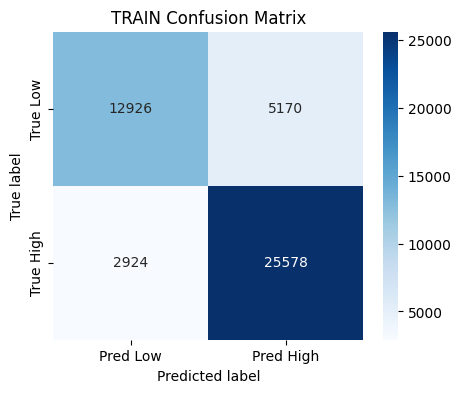

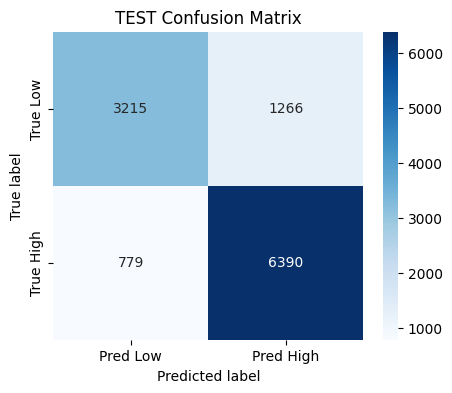

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion(split, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Pred Low", "Pred High"],
                yticklabels=["True Low", "True High"])
    plt.title(f"{split} Confusion Matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

plot_confusion("TRAIN", y_train_true_bin, y_train_pred_bin)
plot_confusion("TEST", y_test_true_bin, y_test_pred_bin)
